<center><h1> A Convolutional Neural Network in Pytorch </h1></center>

In Pytorch, <b>torch.nn</b> package is used to build a neural network. This package contains the definition all layers and functions that you need to design a neural network.<br>
<b>torch.nn</b> provides a base class called <b>nn.Module</b>, a new model should be a subclass it. The new model has to defined:
<ul>
    <li>layers,</li>
    <li>a method <b>forward(input)</b> that return the output.</li>
</ul>
Notice that you just have to define the forward function, the backward function is automatically defined for you using <b>autograd</b>. The <b>autograd</b> package provides automatic differentiation for all operations on Tensors (see more about Tensors at https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py). 

Let's consider a network to classify the digit images:
![](images/example.png)
The network includes:
<ul>
    <li>2 convolutional layers</li>
    <li>2 max pooling layers</li>
    <li>3 full-connected layers</li>
    <li>All the hidden layers use ReLU as activation function</li>
</ul>

<h2>Let's define the network in Pytorch</h2>

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    '''
        Define the layers in the network
    '''
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # (size of input, size of output)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    '''
        Implement the forward computation of the network
    '''
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Loading and normalizing MNIST

Using torchvision to load MNIST dataset 

In [13]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.Resize(32),
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('zero', 'one', 'two', 'three', 'four',
           'five', 'six', 'seven', 'eight', 'nine')

Let's show some of training images and their label

 nine   six  five   two


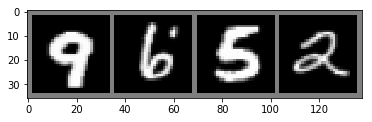

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img/2 + 0.5 # unormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    
dataiter = iter(trainloader)
images,labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

#print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## The loss functions, backward propagation and update the weights
<ul>
    <li>There are several different loss functions in <b>nn</b> package. For example, we use <b>nn.CrossEntropyLoss</b> which compute the loss for a Classification Cross-Entropy.</li>
    <li>To backpropagation the error, we have to call the function <b>loss.backward()</b>. </li>
    <li>The simplest update rule is used Stochastic Gradient Descent (SGD):
<strong> weight = weight - learning_rate * gradient</strong>.
    Pytorch has provided a list of various different update rules such as SGD, Nesterov-SGD, Adam, RMSProp,....in <b>torch.optim</b> package.</li>
</ul>
Let's see how to use it during training the network:

In [16]:
import torch.optim as optim
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

epochs = 2
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader,0):
        #get the input
        inputs, labels = data
        
        # clear the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')


[1,  2000] loss: 1.201
[1,  4000] loss: 0.216
[1,  6000] loss: 0.150
[1,  8000] loss: 0.103
[1, 10000] loss: 0.100
[1, 12000] loss: 0.083
[1, 14000] loss: 0.083
[2,  2000] loss: 0.066
[2,  4000] loss: 0.062
[2,  6000] loss: 0.058
[2,  8000] loss: 0.055
[2, 10000] loss: 0.061
[2, 12000] loss: 0.055
[2, 14000] loss: 0.051
Finished Training


## Test the network on the test data
We have trained the network in 2 epochs over the training dataset. Now, we will check the accuracy of the network by predicting the label of some test images and comparing with the ground truth. <br/>
The first step is display some images from test dataset and their labels.

seven   two   one  zero


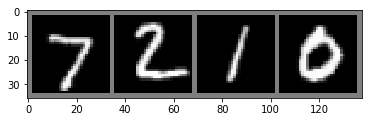

In [17]:
  
dataiter = iter(testloader)
images,labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

#print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Let's see what the network think about the examples:

In [18]:
outputs = net(images)
_,predicted = torch.max(outputs,1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

('Predicted: ', 'seven   two   one  zero')


Let us look at how the network performs on the whole dataset.

In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


## How to train the netwok on GPU?
Let’s first define our device as the first visible cuda device if we have CUDA available:

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda:0


So, if you want to use GPU for training and testing, you have to convert the parameters of the network to CUDA. Remember that you have to send inputs and targets at every step to GPU too.

In [21]:
net.to(device)
inputs, labels = inputs.to(device), labels.to(device) # in each training epoch

/home/linhpc/miniconda2/lib/python2.7/site-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU0 Quadro K600 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))
